### Progressive Growing of GANs

Paper Code: https://github.com/tkarras/progressive_growing_of_gans

Benhmark: 

* https://github.com/jeromerony/Progressive_Growing_of_GANs-PyTorch
* https://github.com/github-pengge/PyTorch-progressive_growing_of_gans


#### Agenda

* Pixelwise Normalization
* Weights Initialization & Normalization

* Growing of Layers
* Alpha Transition Skip Layer

* Discriminator Mini-Batch Standard Deviation Layer
* Downsampling Groundtruth


In [1]:
import torch
import torchvision
import numpy as np
from matplotlib import pyplot as plt
from math import ceil


%matplotlib inline


max_levels = 6  # 1:4x4, 2:8x8, 3:16x16, 4:32x32, 5:64x64, 6:128x128, 7:256x256
image_size = 128  # 4    , 8    , 16     , 32     , 64     , 128     , 256


In [2]:
device = torch.device('cpu')

if torch.cuda.is_available():
    
    device = torch.device('cuda')

#### CelebA Dataset

http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg

In [3]:
dataroot = './celeba'
batch_size = 48
workers = 4

In [4]:
# Squash images to -1 and +1 
class SquashTransform:

    def __call__(self, inputs):
        return 2 * inputs - 1



# Create the dataset
dataset = torchvision.datasets.ImageFolder(
    root=dataroot,
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize(
                image_size),
            torchvision.transforms.CenterCrop(
                image_size),
            torchvision.transforms.ToTensor(),
            SquashTransform()
        ]
    )
)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers
)


num_steps = len(dataloader) // batch_size

num_steps

87

#### Visualize Dataset

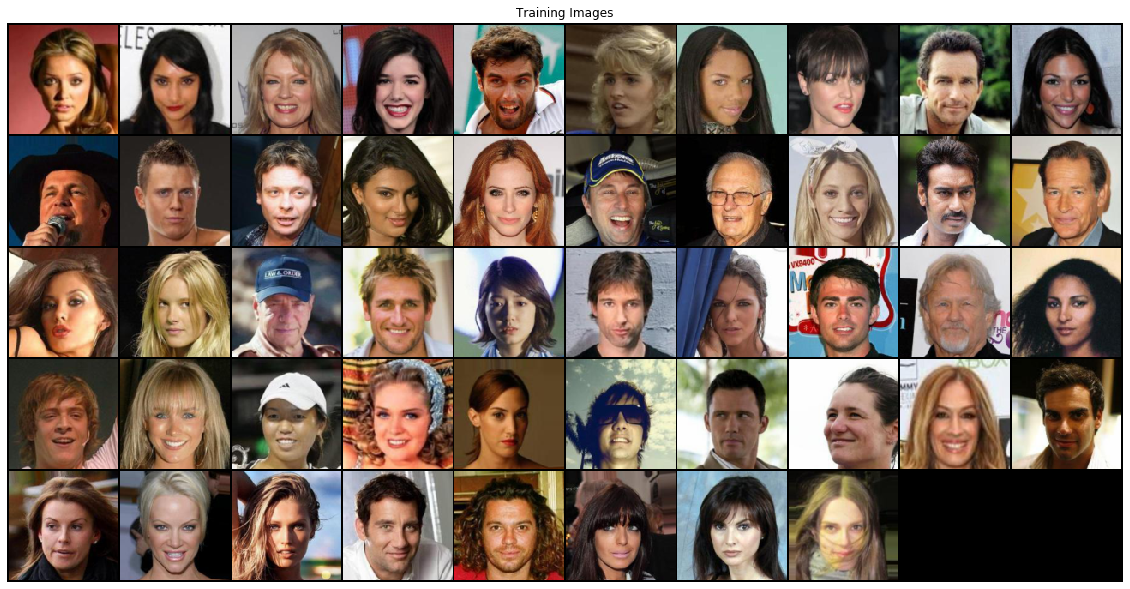

In [5]:
# Plot some training images
real_batch = next(iter(dataloader))

plt.figure(figsize=(20, 20))

plt.axis("off")

plt.title("Training Images")

plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(
            real_batch[0].to(device),
            padding=2,
            normalize=True,
            nrow=10
        ).cpu(),
        (1,2,0)
    )
)

plt.show();

#### Pixelwise Normalization

##### PIXELWISE FEATURE VECTOR NORMALIZATION IN GENERATOR


$$ b_{x, y}=a_{x, y} / \sqrt{\frac{1}{N} \sum_{j=0}^{N-1}\left(a_{x, y}^{j}\right)^{2}+\epsilon} $$

In [6]:
class PixelNormLayer(torch.nn.Module):

    def __init__(self):
        super(PixelNormLayer, self).__init__()

    def forward(self, x):
        return x / torch.sqrt(
            torch.mean(x ** 2, dim=1, keepdim=True) + 1e-8
        )

In [7]:
torch.mean(
    torch.tensor(
        torch.randn((5, 2))
    ),
    dim=0
)

/home/mustafa/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


tensor([ 0.1570, -0.0009])

In [8]:
torch.mean(
    torch.tensor(
        torch.randn((5, 2))
    ),
    dim=1
).shape

/home/mustafa/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


torch.Size([5])

In [9]:
torch.mean(
    torch.tensor(
        torch.randn((5, 2))
    ),
    dim=1,
    keepdim=True
).shape

/home/mustafa/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


torch.Size([5, 1])

/home/mustafa/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


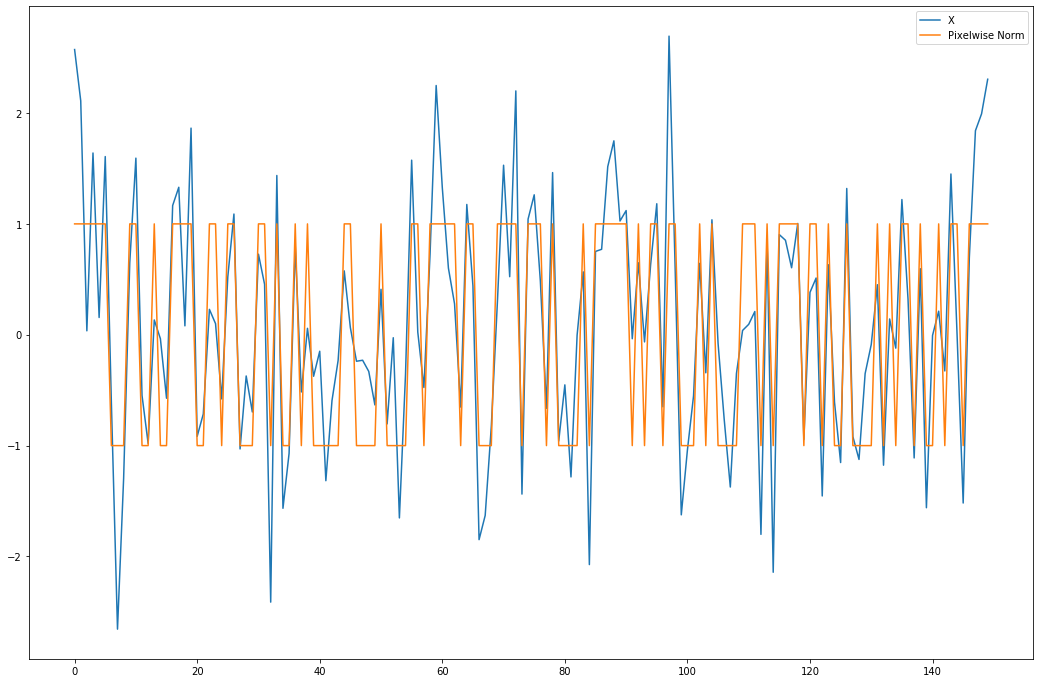

In [10]:
sample = torch.tensor(
    torch.randn((150, 1))
)

l = PixelNormLayer()
norm_sample = l(sample)

plt.figure(figsize=(18, 12))
plt.plot(sample, label='X')
plt.plot(norm_sample, label='Pixelwise Norm')
plt.legend()
plt.show();

#### Weights Normalization

##### EQUALIZED LEARNING RATE

$$ \hat{w}_{i}=w_{i} / c $$

$$ c = \sqrt{ 2 / N } $$

In [11]:
class WScaleLayer(torch.nn.Module):

    def __init__(self, incoming, gain=2):

        super(WScaleLayer, self).__init__()

        self.gain = gain
        self.scale = (self.gain / incoming.weight[0].numel()) ** 0.5

    def forward(self, input):
        return input * self.scale


#### Architecture

<img src="https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/744fe47157477235032f7bb3777800f9f2f45e52/4-Figure2-1.png" />

#### Generator Convolutional Block

In [12]:
def GConvBlock(
    in_channels,
    out_channels,
    kernel_size,
    stride,
    padding,
    bias
):
    
    return torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=bias
            ),
            torch.nn.BatchNorm2d(
                num_features=out_channels
            ),
            torch.nn.ReLU(
                inplace=True
            ),
            PixelNormLayer()
    )

#### Discriminator Convolutional Block

In [13]:
def DConvBlock(
    in_channels,
    out_channels,
    kernel_size,
    stride,
    padding,
    bias
):

    return torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=bias
            ),
            torch.nn.BatchNorm2d(
                num_features=out_channels
            ),
            torch.nn.LeakyReLU(
                negative_slope=0.2,
                inplace=True
            )
    )

#### Global Variables

In [14]:
# Number of channels in the training images.
# For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 150

# Size of feature maps in generator
ngf = 6

# Size of feature maps in discriminator
ndf = 6

#### Generator Design

In [15]:
class Generator(torch.nn.Module):

    def __init__(self):

        super(Generator, self).__init__()
        
        self.blocks = torch.nn.ModuleList()
        self.toRGBs = torch.nn.ModuleList()
        
        # first conv block
        self.blocks.append(
            torch.nn.Sequential(
                GConvBlock(
                    in_channels=nz,
                    out_channels=ngf * 48,
                    kernel_size=4,
                    stride=1,
                    padding=0,
                    bias=False
                ),
                GConvBlock(
                    in_channels=ngf * 48,
                    out_channels=ngf * 32,
                    kernel_size=1,
                    stride=1,
                    padding=0,
                    bias=False
                )
            )
        )

        # growing conv blocks: 4 * 4, 8 * 8, 16 * 16, 32 * 32, 64 * 64
        i = 5  # channels sentinent
        j = 4  # size sentinent
        
        while j <= image_size:
            
            in_channels = int(
                ngf * ( 2 ** i )
            )  # 32 => 16 => 8 => 4 => 2
            out_channels = int(
                ngf * ( 2 ** (i - 1) )
            )  # 16 => 8  => 4 => 2 => 1
            
            self.blocks.append(
                torch.nn.Sequential(
                    GConvBlock(
                        in_channels=in_channels,  
                        out_channels=in_channels,
                        kernel_size=4,
                        stride=2,
                        padding=1,
                        bias=False
                    ),
                    GConvBlock(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=1,
                        stride=1,
                        padding=0,
                        bias=False
                    )
                )
            )
            
            self.toRGBs.append(
                torch.nn.Sequential(
                    torch.nn.ConvTranspose2d(
                        in_channels=in_channels,
                        out_channels=nc,
                        kernel_size=1,
                        stride=1,
                        padding=0,
                        bias=False
                    ),
                    torch.nn.Tanh()
                )
            )
            
            i = i - 1
            j = j * 2
        
        # Weight Initialization
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(
                    m.weight)
                if m.bias is not None:
                    torch.nn.init.constant_(
                        m.bias, 0)
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(
                    m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)

    # level = 1: 4x4, 2: 8x8, 3: 16x16, 4: 32x32, 5:64x64
    def forward(self, inputs, level):
        
        alpha = False  # level - int(level)
        level = min(int(ceil(level)), max_levels)
        
        feature_map = self.blocks[0](inputs)
                
        for i in range(1, level):

            feature_map = self.blocks[i](
                feature_map)
                        
            # alpha transition
            if level > 1 and i == level-1 and alpha != 0:
        
                # upsample 2x
#                 prev_output = torch.nn.functional.upsample(
#                     feature_map,
#                     scale_factor=2
#                 )
                        
                prev_output = self.toRGBs[i](
                    feature_map)

        output = self.toRGBs[level-1](feature_map)
        
        if alpha != 0:
            return output * alpha + prev_output * ( 1 - alpha )
        else:
            return output
        

#### Discriminator Design

In [16]:
class Discriminator(torch.nn.Module):

    def __init__(self):

        super(Discriminator, self).__init__()
        
        self.fromRGBs = torch.nn.ModuleList()
        self.blocks = torch.nn.ModuleList()

        # opposite growing conv blocks: 4 * 4, 8 * 8, 16 * 16, 32 * 32, 64 * 64
        i = 0  # channels sentinent
        j = 4  # size sentinent
        
        while j <= image_size:
            
            in_channels = int(
                ndf * ( 2 ** i )
            )  # 1 => 2 => 4 => 8  => 16
            out_channels =int(
                ndf * ( 2 ** (i + 1) )
            )  # 2 => 4 => 8 => 16 => 32
            
            self.fromRGBs.append(
                torch.nn.Sequential(
                    torch.nn.Conv2d(
                        in_channels=nc,
                        out_channels=in_channels,
                        kernel_size=1,
                        stride=1,
                        padding=0,
                        bias=False
                    ),
                    torch.nn.LeakyReLU(
                        negative_slope=0.2,
                        inplace=True
                    )
                )
            )
            
            self.blocks.append(
                torch.nn.Sequential(
                    DConvBlock(
                        in_channels=in_channels,
                        out_channels=in_channels,
                        kernel_size=4,
                        stride=2,
                        padding=1,
                        bias=False
                    ),
                    DConvBlock(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=1,
                        stride=1,
                        padding=0,
                        bias=False
                    )
                )
            )
            
            i = i + 1
            j = j * 2
        
        # add last block
        self.blocks.append(
            torch.nn.Sequential(
                torch.nn.Conv2d(
                    in_channels=ndf * ( 2 ** (i + 1) ),
                    out_channels=1,
                    kernel_size=2,
                    stride=1,
                    padding=0,
                    bias=False
                ),
                torch.nn.Sigmoid()
            )
        )
        
        # Weight Initialization
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)

    # level = 1: 4x4, 2: 8x8, 3: 16x16, 4: 32x32, 5:64x64
    def forward(self, inputs, level): 
        
        alpha = False  # level - int(level)
        level = min(int(ceil(level)), max_levels)
        
        feature_map = self.fromRGBs[max_levels - level](inputs)
        feature_map = self.blocks[max_levels - level](feature_map)
        
        # alpha transition
        if level > 1 and alpha != 0:
            
            # downsample 0.5x
            prev_input = torch.nn.functional.avg_pool2d(
                inputs,
                kernel_size=2,
                stride=2
            )
            
            prev_feature_map = self.fromRGBs[max_levels - level + 1](prev_input)
            
            # alpha merge
            feature_map = alpha * feature_map + ( 1 - alpha ) * prev_feature_map
        
        for i in range(max_levels - level + 1, max_levels):            
            
            feature_map = self.blocks[i](feature_map)
        
        # standard deviation per mini batch
        stdv = torch.std(feature_map, dim=0)

        # concatenate feature map and stdv
        y = torch.cat(
            (
                feature_map,
                stdv.unsqueeze(0).expand_as(
                    feature_map
                )
            ),
            dim=1
        )

        # pass through last layer
        ret = self.blocks[-1](y).view(-1, 1)

        return ret

#### Visualize Networks

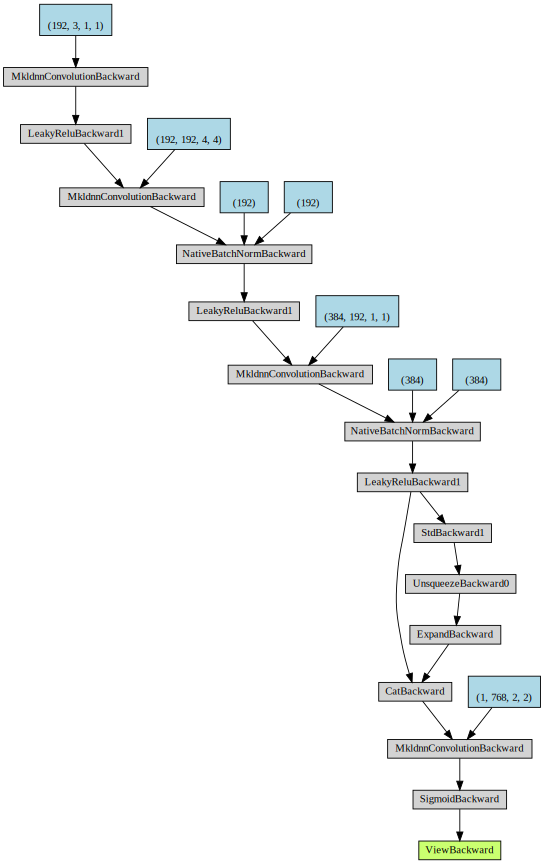

In [17]:
from torchviz import make_dot


netD = Discriminator()
out = netD(torch.zeros(1, 3, 4, 4), level=1)
make_dot(out)

In [18]:
netD

Discriminator(
  (fromRGBs): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 6, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(3, 12, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(3, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(3, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(3, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (5): Sequential(
      (0): Conv2d(3, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (blocks): ModuleList(
    (0)

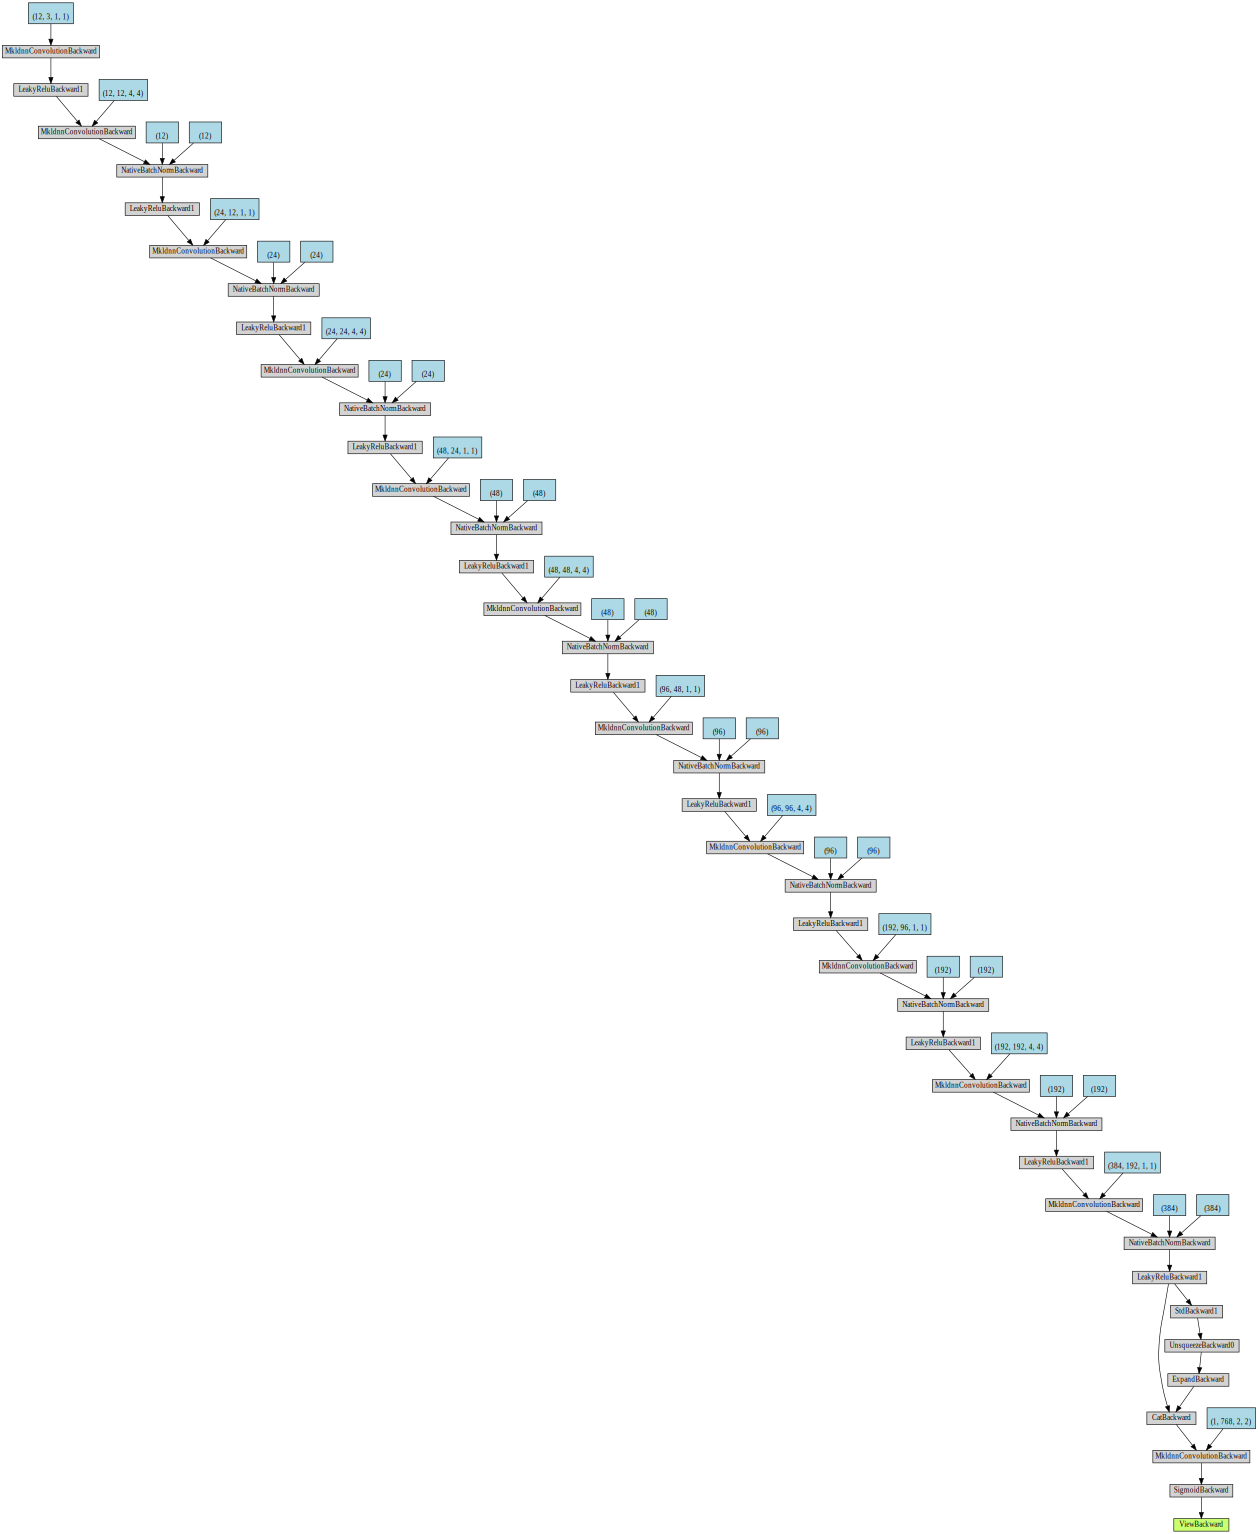

In [19]:
out = netD(torch.zeros(1, 3, 64, 64), level=5)
make_dot(out)

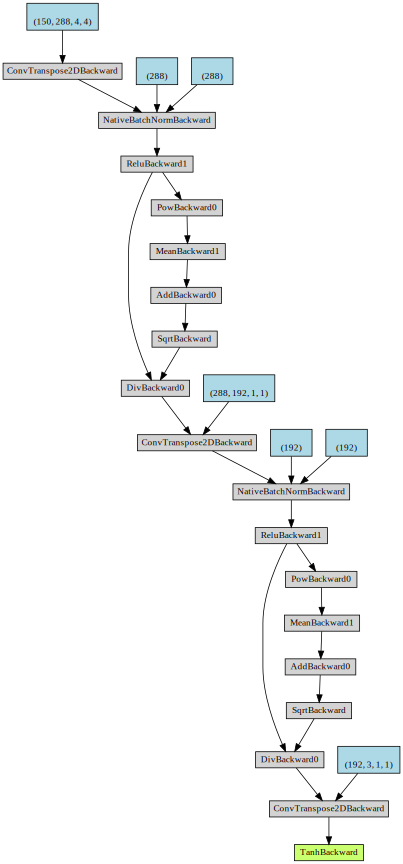

In [20]:
netG = Generator()
out = netG(torch.zeros(1, nz, 1, 1), level=1)
make_dot(out)

In [21]:
netG

Generator(
  (blocks): ModuleList(
    (0): Sequential(
      (0): Sequential(
        (0): ConvTranspose2d(150, 288, kernel_size=(4, 4), stride=(1, 1), bias=False)
        (1): BatchNorm2d(288, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): PixelNormLayer()
      )
      (1): Sequential(
        (0): ConvTranspose2d(288, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): PixelNormLayer()
      )
    )
    (1): Sequential(
      (0): Sequential(
        (0): ConvTranspose2d(192, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): PixelNormLayer()
      )
      (1): Sequential(
        (0): ConvTranspose2d(192, 96, kernel_size=(1, 1), s

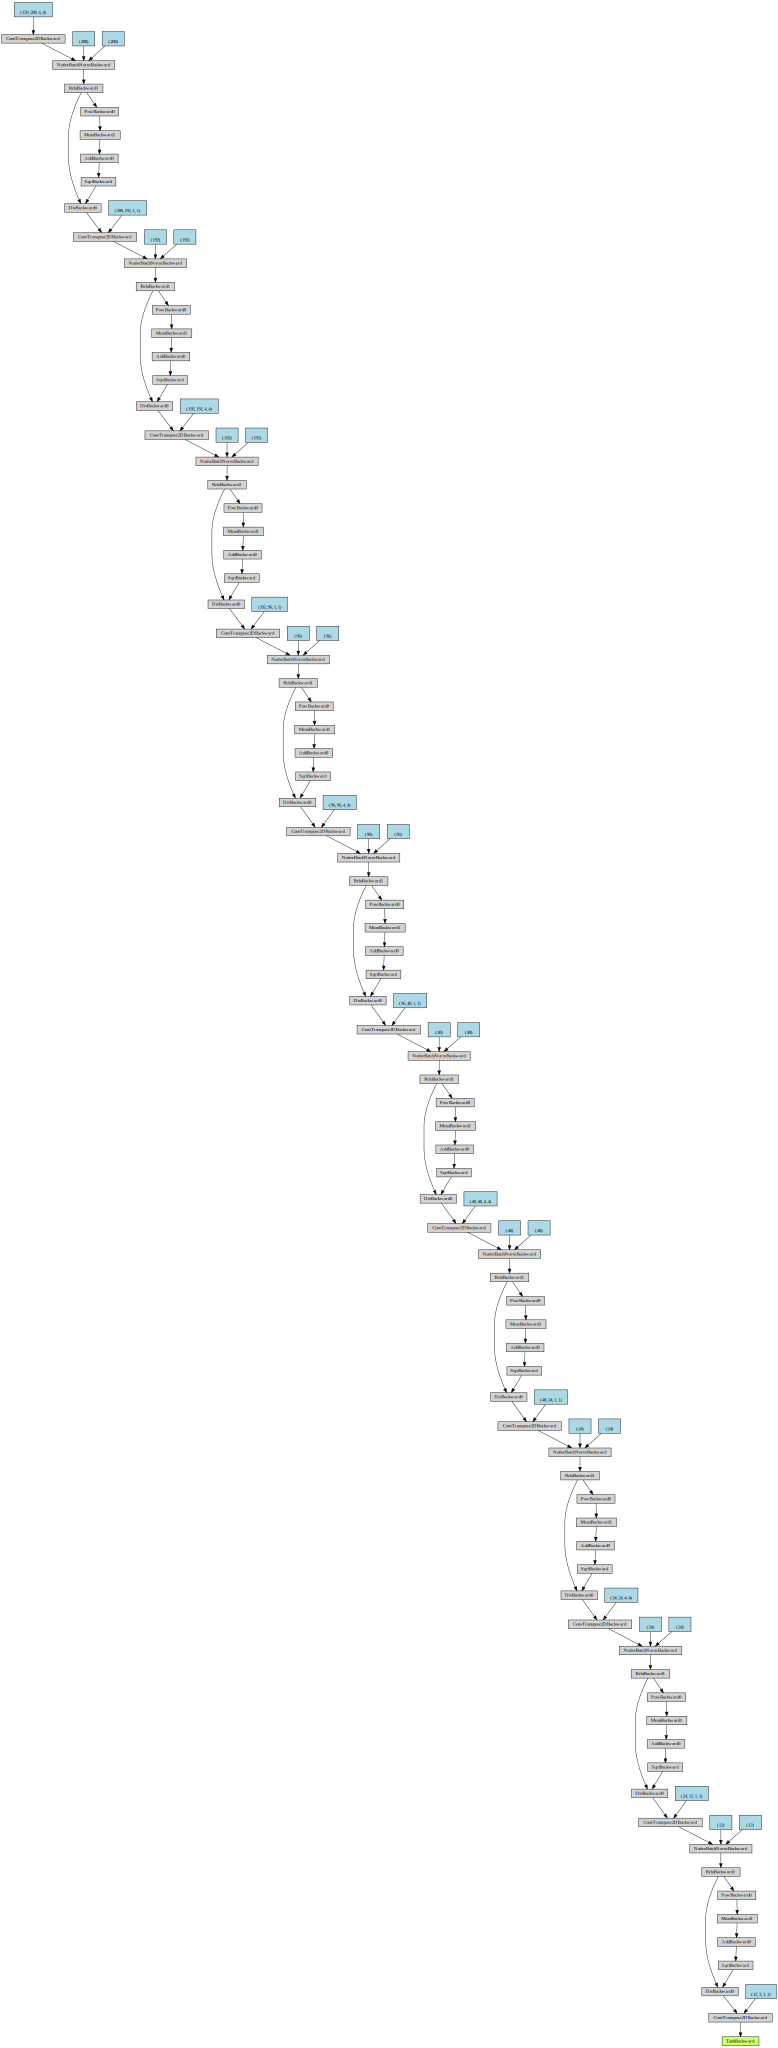

In [22]:
out = netG(torch.zeros(1, nz, 1, 1), level=5)
make_dot(out)

#### Unit Testing

In [23]:
for i in np.arange(1.00009, max_levels+0.2, 0.1):
    
    rounded_level = min(int(ceil(i)), max_levels)
        
    out = netG(torch.zeros(batch_size, nz, 1, 1), level=i)
    
    assert out.shape == (batch_size, 3, 4 * (2 ** (rounded_level-1)), 4 * (2 ** (rounded_level-1))), "G Output Shape={}".format(out.shape)

    valid = netD(out, level=i)
    
    assert valid.shape == (batch_size, 1), "D Output Shape={}".format(valid.shape)
    
    print(
        'Verified Size {} x {} \t @ Level {}'.format(
            4 * ( 2 ** (rounded_level-1)),
            4 * ( 2 ** (rounded_level-1)),
            i
        )
    )

Verified Size 8 x 8 	 @ Level 1.00009
Verified Size 8 x 8 	 @ Level 1.10009
Verified Size 8 x 8 	 @ Level 1.20009
Verified Size 8 x 8 	 @ Level 1.3000900000000002
Verified Size 8 x 8 	 @ Level 1.4000900000000003
Verified Size 8 x 8 	 @ Level 1.5000900000000004
Verified Size 8 x 8 	 @ Level 1.6000900000000005
Verified Size 8 x 8 	 @ Level 1.7000900000000005
Verified Size 8 x 8 	 @ Level 1.8000900000000006
Verified Size 8 x 8 	 @ Level 1.9000900000000007
Verified Size 16 x 16 	 @ Level 2.000090000000001
Verified Size 16 x 16 	 @ Level 2.1000900000000007
Verified Size 16 x 16 	 @ Level 2.200090000000001
Verified Size 16 x 16 	 @ Level 2.300090000000001
Verified Size 16 x 16 	 @ Level 2.4000900000000014
Verified Size 16 x 16 	 @ Level 2.500090000000001
Verified Size 16 x 16 	 @ Level 2.6000900000000016
Verified Size 16 x 16 	 @ Level 2.700090000000001
Verified Size 16 x 16 	 @ Level 2.8000900000000017
Verified Size 16 x 16 	 @ Level 2.9000900000000014
Verified Size 32 x 32 	 @ Level 3.0000

#### Convert Model to GPU

In [24]:
netD = netD.to(device)
netG = netG.to(device)

#### Optimizer

In [25]:
# Setup Adam optimizers for both G and D
optimizerD = torch.optim.RMSprop(
    netD.parameters(),
    lr=0.0001
)

optimizerG = torch.optim.RMSprop(
    netG.parameters(),
    lr=0.0001
)

In [26]:
criterion = torch.nn.BCELoss()

fixed_noise = torch.randn(
    25, nz, 1, 1
).to(device)

real_labels = torch.ones(batch_size, 1).to(device)
fake_labels = torch.zeros(batch_size, 1).to(device)

#### Train Discriminator

In [27]:
def trainD(images, level):

    real_images = images.to(device)

    fake_images = netG(
        torch.randn(
            batch_size, nz, 1, 1
        ).to(device),
        level
    )

    optimizerD.zero_grad()

    real_outputs = netD(real_images, level)
    fake_outputs = netD(fake_images, level)

    d_x = criterion(real_outputs, real_labels)
    d_g_z = criterion(fake_outputs, fake_labels)

    d_x.backward()
    d_g_z.backward()

    optimizerD.step()

    loss = d_x + d_g_z
    
    return loss

#### Train Generator

In [28]:
def trainG(level):
    z = torch.randn(
        batch_size, nz, 1, 1
    ).to(device)

    netG.zero_grad()

    outputs = netD(
        netG(z, level),
        level
    )

    loss = criterion(outputs, real_labels)

    loss.backward()

    optimizerG.step()

    return loss

#### Control Progressive Growing

In [29]:
# standardize to range [0 - 1] then scale to range [1, max_levels]
def updateLevel(epoch, step, total_epochs, total_steps, max_levels):
    
    total_spectrum = total_epochs * total_steps
    
    current_point = epoch * total_steps + step
    
    return min( 
        max( 
            (current_point / total_spectrum ) * max_levels, 4), max_levels)

In [30]:
ret = []
res = []

for i in range(50):
    for j in range(20):
        level = updateLevel(i, j, 50, 20, max_levels)
        ret.append(level)
        res.append(2 ** (ceil(level + 1.001)))

print(ret, res)

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

#### Downsample Image Batch

In [31]:
def downsampleMiniBatch(images, level):
    
    level = min(int(ceil(level)), max_levels)

    d = 4 * (2 ** (level - 1))
        
    return torch.nn.functional.adaptive_avg_pool2d(
                images,
                output_size=d
            )

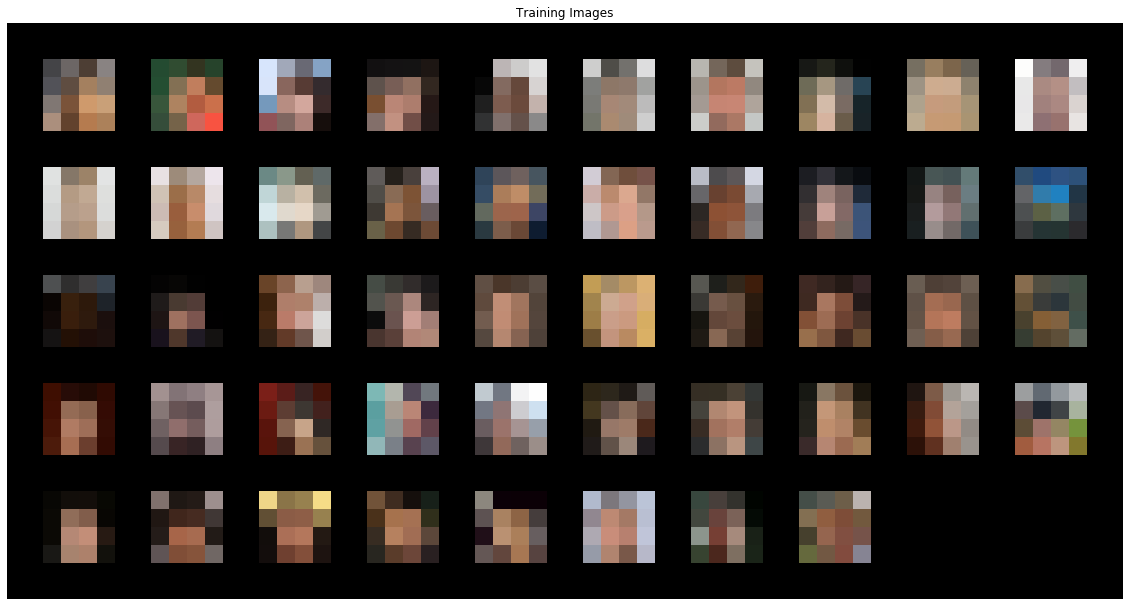

In [32]:
# Plot some training images at 4 x 4 resolution
real_batch = next(iter(dataloader))

resized_batch = downsampleMiniBatch(real_batch[0], 1)

plt.figure(figsize=(20, 20))

plt.axis("off")

plt.title("Training Images")

plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(
            resized_batch,
            padding=2,
            normalize=True,
            nrow=10
        ),
        (1,2,0)
    )
)

plt.show();

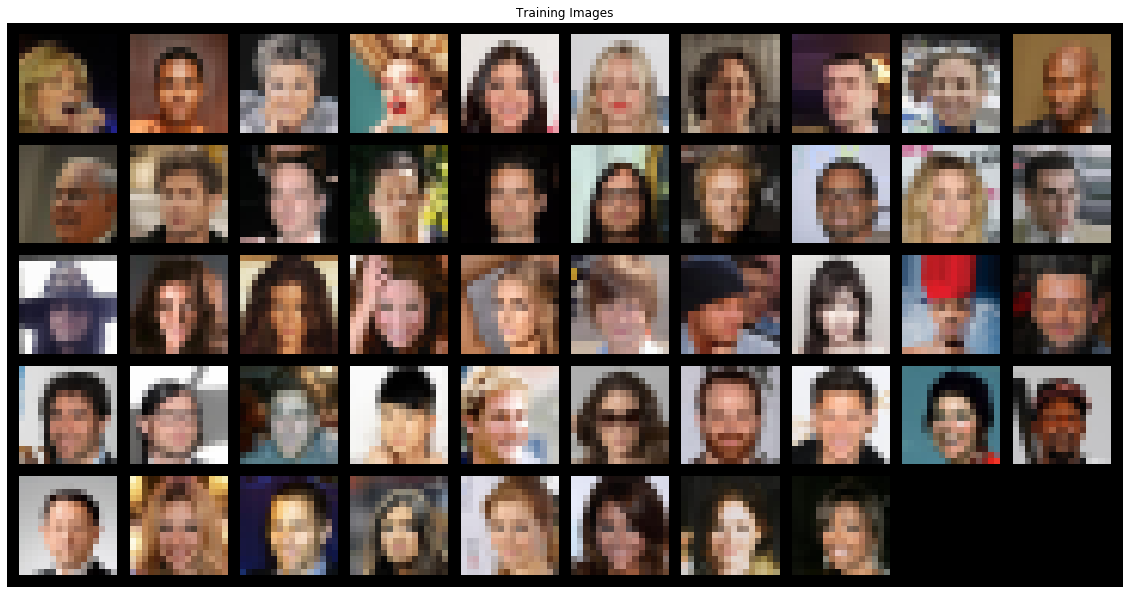

In [33]:
# Plot some training images at 16 x 16 resolution
real_batch = next(iter(dataloader))

resized_batch = downsampleMiniBatch(real_batch[0], 3)

plt.figure(figsize=(20, 20))

plt.axis("off")

plt.title("Training Images")

plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(
            resized_batch,
            padding=2,
            normalize=True,
            nrow=10
        ),
        (1,2,0)
    )
)

plt.show();

#### Train Networks

In [34]:
from math import floor


# https://pytorch.org/docs/stable/tensorboard.html
from torch.utils.tensorboard import SummaryWriter


# Writer will output to ./runs/ directory by default
tb_writer = SummaryWriter()



import os

# checkpoints
if os.path.exists('section-5-optim-d.pytorch'):
    optimizerD.load_state_dict(torch.load('section-5-optim-d.pytorch'))
    
if os.path.exists('section-5-optim-g.pytorch'):
    optimizerG.load_state_dict(torch.load('section-5-optim-g.pytorch'))

if os.path.exists('section-5-network-d.pytorch'):
    netD.load_state_dict(torch.load('section-5-network-d.pytorch'))

if os.path.exists('section-5-network-g.pytorch'):
    netG.load_state_dict(torch.load('section-5-network-g.pytorch'))



num_epochs = 2551


for epoch in range(num_epochs):
    
    d_loss = 0
    g_loss = 0
    
    for i, (images, _) in enumerate(dataloader):

        if i == num_steps:
            break
        
        level = updateLevel(epoch, i, num_epochs, num_steps, max_levels) + 0.00009

        for k in range(1):
            
            images = downsampleMiniBatch(images, level)
            
            d_loss += trainD(
                 images,
                 level
            )

        g_loss += trainG(level)

    
    # Log & save checkpoint only every X epochs
    if epoch % 10 == 0:
        
        # G & D Loss
        print(
            "E:{}, L:{}, G Loss:{}, D Loss:{}".format(
                epoch,
                level,
                g_loss / num_steps,
                d_loss / num_steps
            )
        )
        
        # checkpoints
        torch.save(optimizerD.state_dict(), 'section-5-optim-d.pytorch')
        torch.save(optimizerG.state_dict(), 'section-5-optim-g.pytorch')
        torch.save(netD.state_dict(), 'section-5-network-d.pytorch')
        torch.save(netG.state_dict(), 'section-5-network-g.pytorch')
                
        generated = netG(fixed_noise, ceil(level)).detach().cpu()
        
#         .view(
#             -1,
#             3,
#             2 ** (ceil(level + 1.00001)),
#             2 ** (ceil(level + 1.00001))
#         )

        grid = torchvision.utils.make_grid(
            generated,
            nrow=5,
            padding=10,
            pad_value=1,
            normalize=True
        )

        tb_writer.add_image(
            'PGGAN/Output',
            grid,
            epoch
        )

/home/mustafa/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mustafa/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mustafa/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mustafa/.local/lib/python3.6/site-packages/tensorboard/compat

E:0, L:4.00009, G Loss:63.12200164794922, D Loss:0.0
E:10, L:4.00009, G Loss:63.3973274230957, D Loss:0.0
E:20, L:4.00009, G Loss:63.29313278198242, D Loss:0.0
E:30, L:4.00009, G Loss:63.2193603515625, D Loss:0.0
E:40, L:4.00009, G Loss:62.89963912963867, D Loss:0.0
E:50, L:4.00009, G Loss:63.07286071777344, D Loss:0.0
E:60, L:4.00009, G Loss:63.13206481933594, D Loss:0.0
E:70, L:4.00009, G Loss:63.27947235107422, D Loss:0.0
E:80, L:4.00009, G Loss:63.0543212890625, D Loss:0.0
E:90, L:4.00009, G Loss:63.22580337524414, D Loss:0.0
E:100, L:4.00009, G Loss:62.993221282958984, D Loss:0.0
E:110, L:4.00009, G Loss:63.112091064453125, D Loss:0.0
E:120, L:4.00009, G Loss:63.07062530517578, D Loss:0.0
E:130, L:4.00009, G Loss:63.35679244995117, D Loss:0.0
E:140, L:4.00009, G Loss:63.12051010131836, D Loss:0.0
E:150, L:4.00009, G Loss:63.12217712402344, D Loss:0.0
E:160, L:4.00009, G Loss:63.10505294799805, D Loss:0.0
E:170, L:4.00009, G Loss:63.03017807006836, D Loss:0.0
E:180, L:4.00009, G Lo

E:1480, L:4.00009, G Loss:62.93981170654297, D Loss:0.0
E:1490, L:4.00009, G Loss:62.81288528442383, D Loss:0.0
E:1500, L:4.00009, G Loss:62.834388732910156, D Loss:0.0
E:1510, L:4.00009, G Loss:62.77220153808594, D Loss:0.0
E:1520, L:4.00009, G Loss:62.751468658447266, D Loss:0.0
E:1530, L:4.00009, G Loss:62.91122055053711, D Loss:0.0
E:1540, L:4.00009, G Loss:62.833282470703125, D Loss:0.0
E:1550, L:4.00009, G Loss:62.49736022949219, D Loss:0.0
E:1560, L:4.00009, G Loss:62.8756103515625, D Loss:0.0
E:1570, L:4.00009, G Loss:62.756690979003906, D Loss:0.0
E:1580, L:4.00009, G Loss:63.04808807373047, D Loss:0.0
E:1590, L:4.00009, G Loss:63.06230163574219, D Loss:0.0
E:1600, L:4.00009, G Loss:62.84661865234375, D Loss:0.0
E:1610, L:4.00009, G Loss:63.05579376220703, D Loss:0.0
E:1620, L:4.00009, G Loss:62.99626922607422, D Loss:0.0
E:1630, L:4.00009, G Loss:62.471824645996094, D Loss:0.0
E:1640, L:4.00009, G Loss:62.79247283935547, D Loss:0.0
E:1650, L:4.00009, G Loss:62.71322250366211,

In [35]:
# checkpoints
torch.save(optimizerD.state_dict(), 'section-5-optim-d.pytorch')
torch.save(optimizerG.state_dict(), 'section-5-optim-g.pytorch')
torch.save(netD.state_dict(), 'section-5-network-d.pytorch')
torch.save(netG.state_dict(), 'section-5-network-g.pytorch')

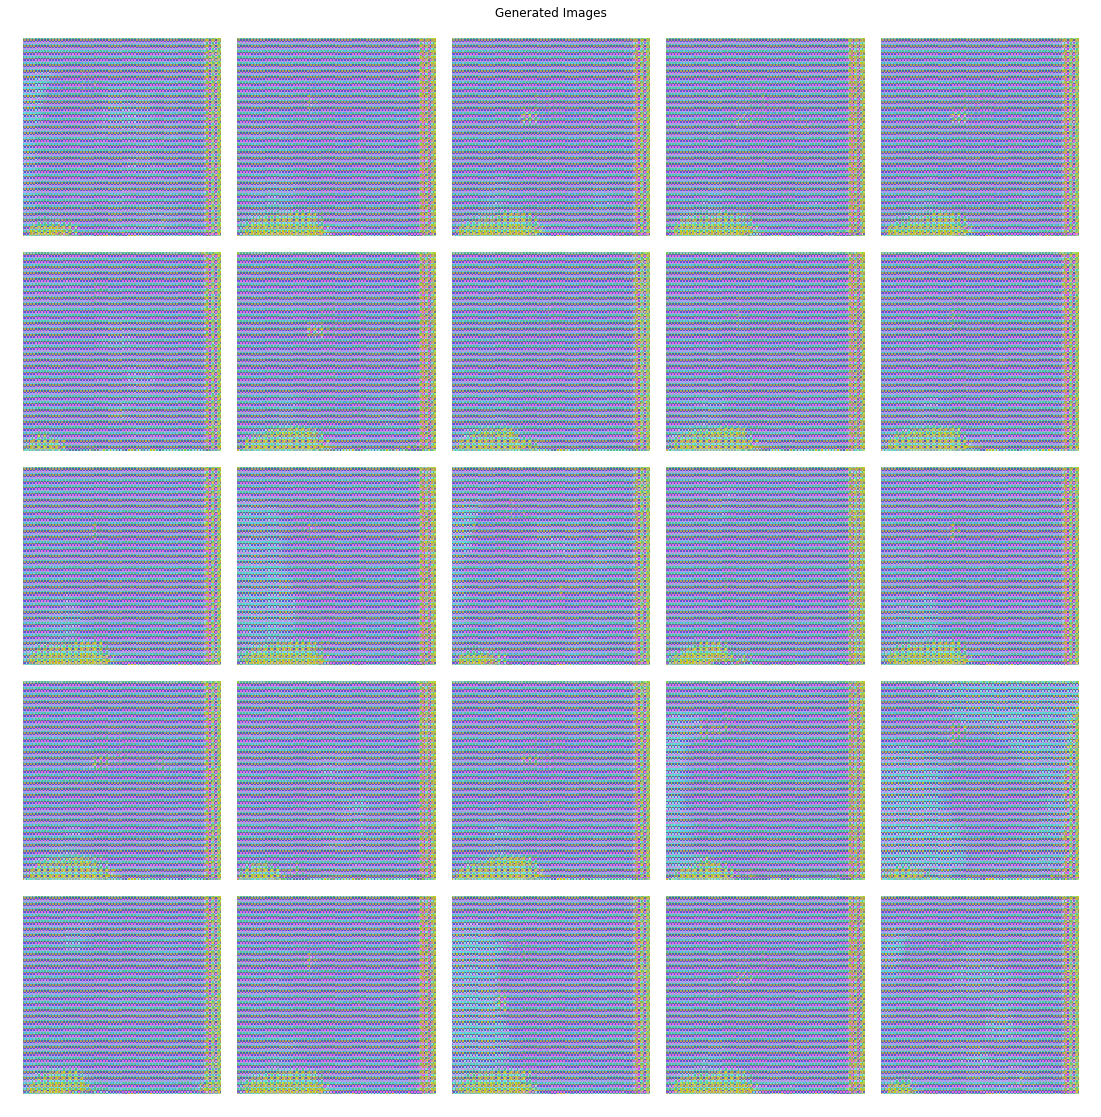

In [36]:
generated = netG(fixed_noise, level=max_levels).detach().cpu().view(-1, 3, image_size, image_size)


grid = torchvision.utils.make_grid(
    generated,
    nrow=5,
    padding=10,
    pad_value=1,
    normalize=True,
    range=(-1, 1)
)


plt.figure(figsize=(22, 20))
plt.axis("off")
plt.title("Generated Images")

plt.imshow(
    np.transpose(
        grid,
        (1,2,0)
    )
);

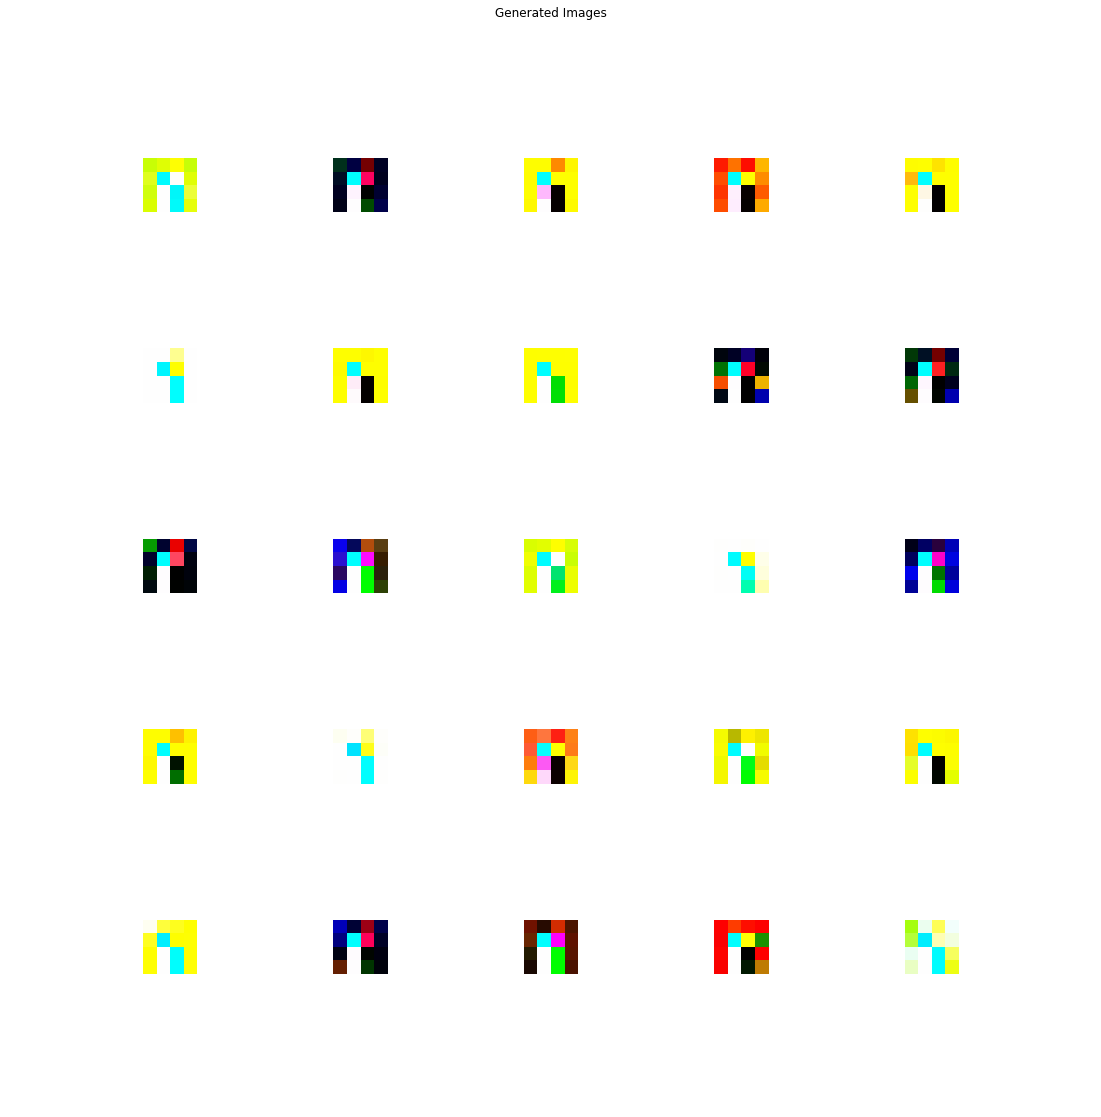

In [37]:
generated = netG(fixed_noise, level=1).detach().cpu().view(-1, 3, 4, 4)


grid = torchvision.utils.make_grid(
    generated,
    nrow=5,
    padding=10,
    pad_value=1,
    normalize=True,
    range=(-1, 1)
)


plt.figure(figsize=(22, 20))
plt.axis("off")
plt.title("Generated Images")

plt.imshow(
    np.transpose(
        grid,
        (1,2,0)
    )
);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


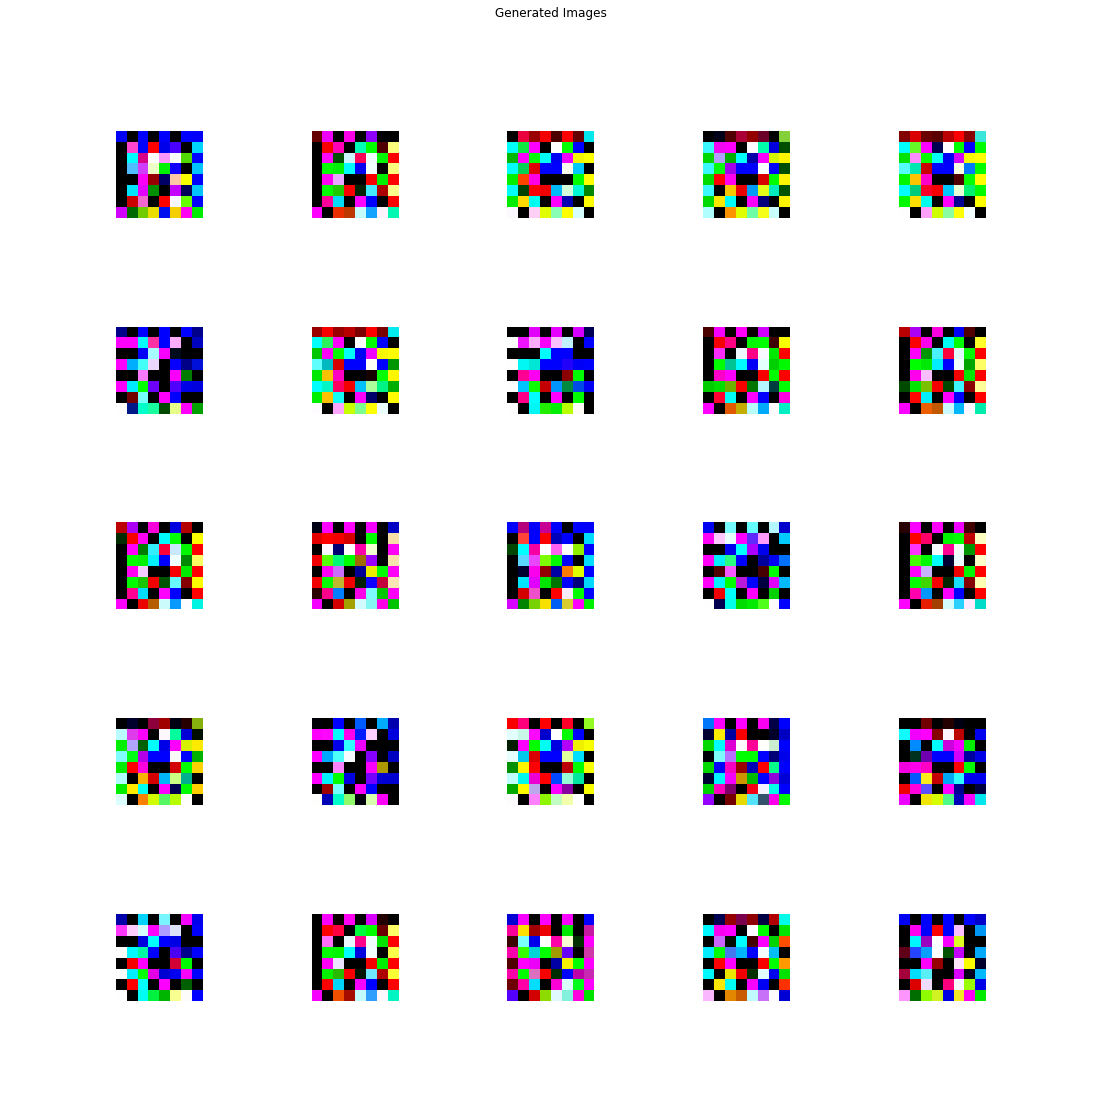

In [38]:
generated = netG(fixed_noise, level=2).detach().cpu().view(-1, 3, 8, 8)


grid = torchvision.utils.make_grid(
    generated,
    nrow=5,
    padding=10,
    pad_value=1,
    normalize=False,
#     range=(-1, 1)
)


plt.figure(figsize=(22, 20))
plt.axis("off")
plt.title("Generated Images")

plt.imshow(
    np.transpose(
        grid,
        (1,2,0)
    )
);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


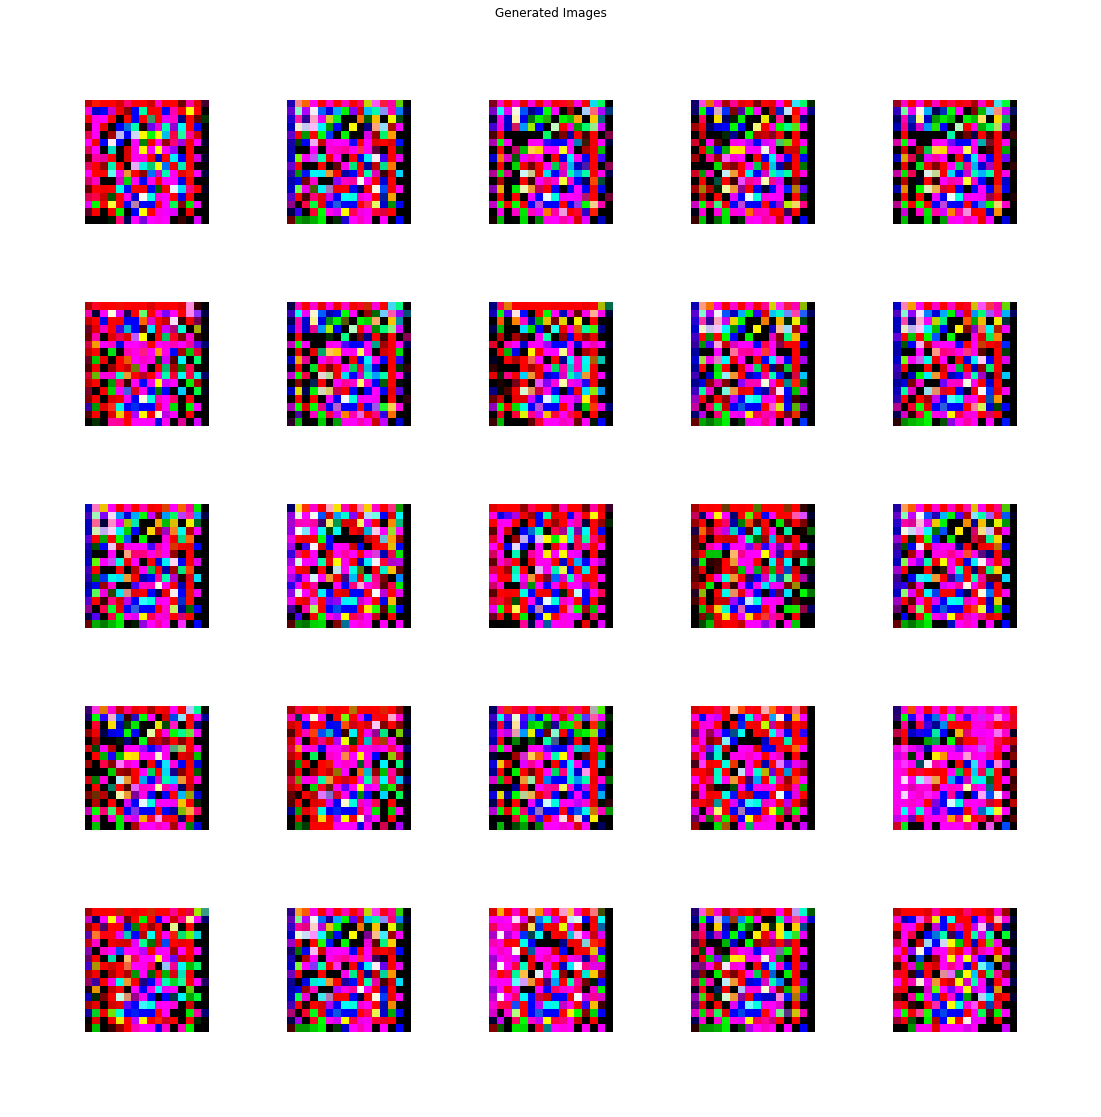

In [39]:
generated = netG(fixed_noise, level=3).detach().cpu().view(-1, 3, 16, 16)


grid = torchvision.utils.make_grid(
    generated,
    nrow=5,
    padding=10,
    pad_value=1,
    normalize=False,
#     range=(-1, 1)
)


plt.figure(figsize=(22, 20))
plt.axis("off")
plt.title("Generated Images")

plt.imshow(
    np.transpose(
        grid,
        (1,2,0)
    )
);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


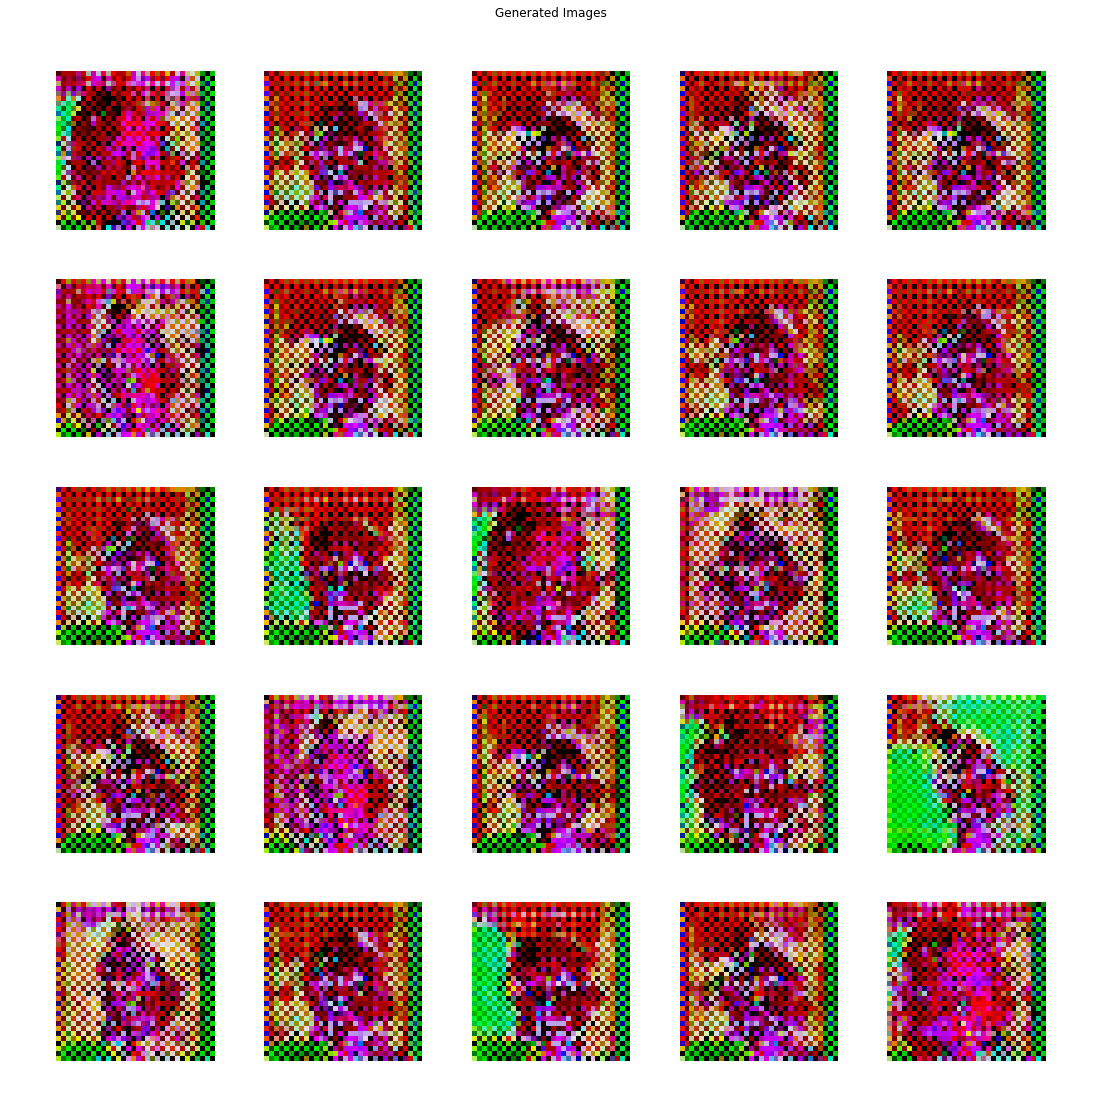

In [40]:
generated = netG(fixed_noise, level=4).detach().cpu().view(-1, 3, 32, 32)


grid = torchvision.utils.make_grid(
    generated,
    nrow=5,
    padding=10,
    pad_value=1,
    normalize=False,
#     range=(-1, 1)
)


plt.figure(figsize=(22, 20))
plt.axis("off")
plt.title("Generated Images")

plt.imshow(
    np.transpose(
        grid,
        (1,2,0)
    )
);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


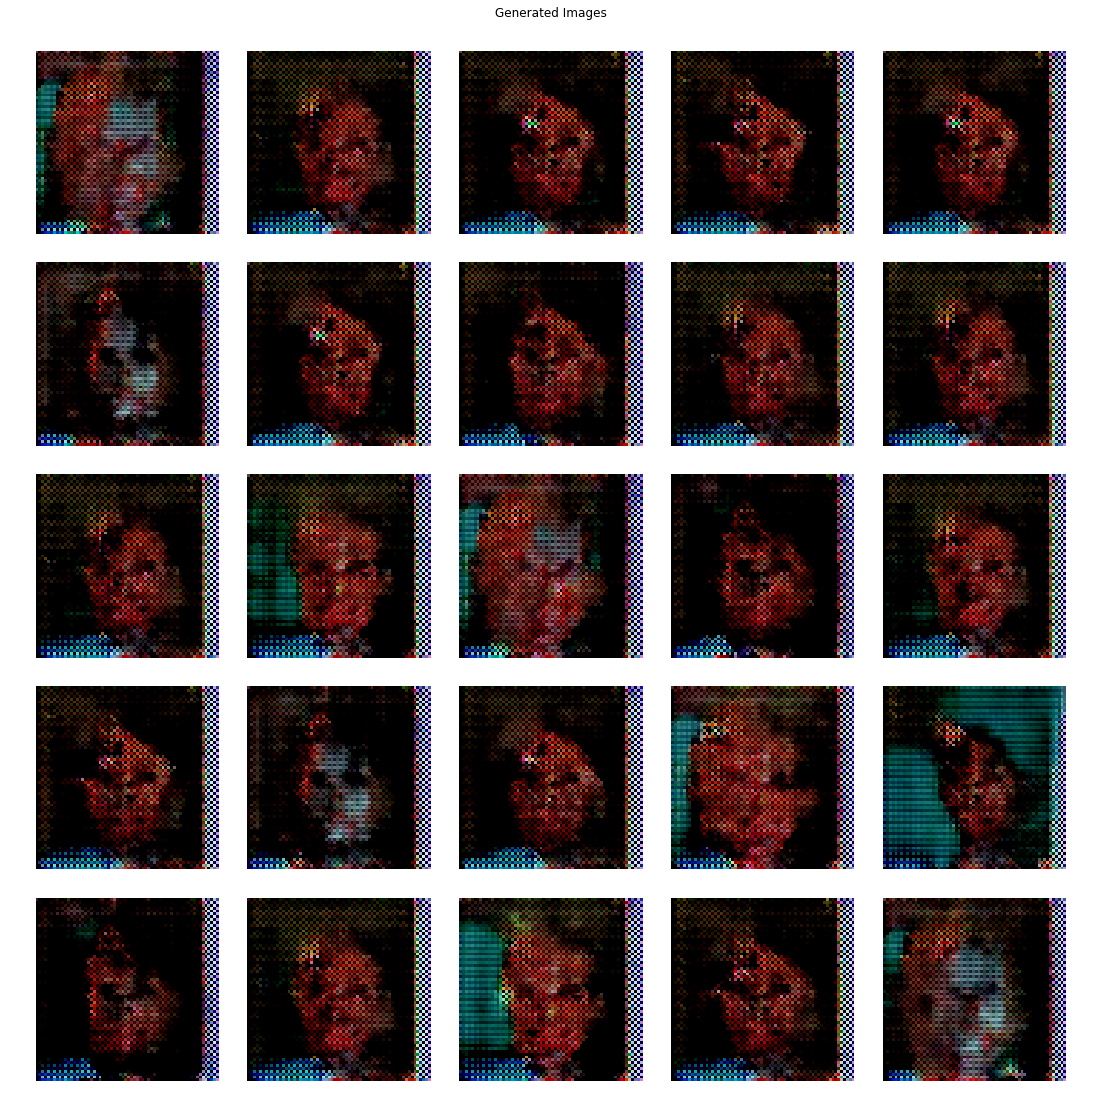

In [41]:
generated = netG(fixed_noise, level=5).detach().cpu().view(-1, 3, 64, 64)


grid = torchvision.utils.make_grid(
    generated,
    nrow=5,
    padding=10,
    pad_value=1,
    normalize=False,
#     range=(-1, 1)
)


plt.figure(figsize=(22, 20))
plt.axis("off")
plt.title("Generated Images")

plt.imshow(
    np.transpose(
        grid,
        (1,2,0)
    )
);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


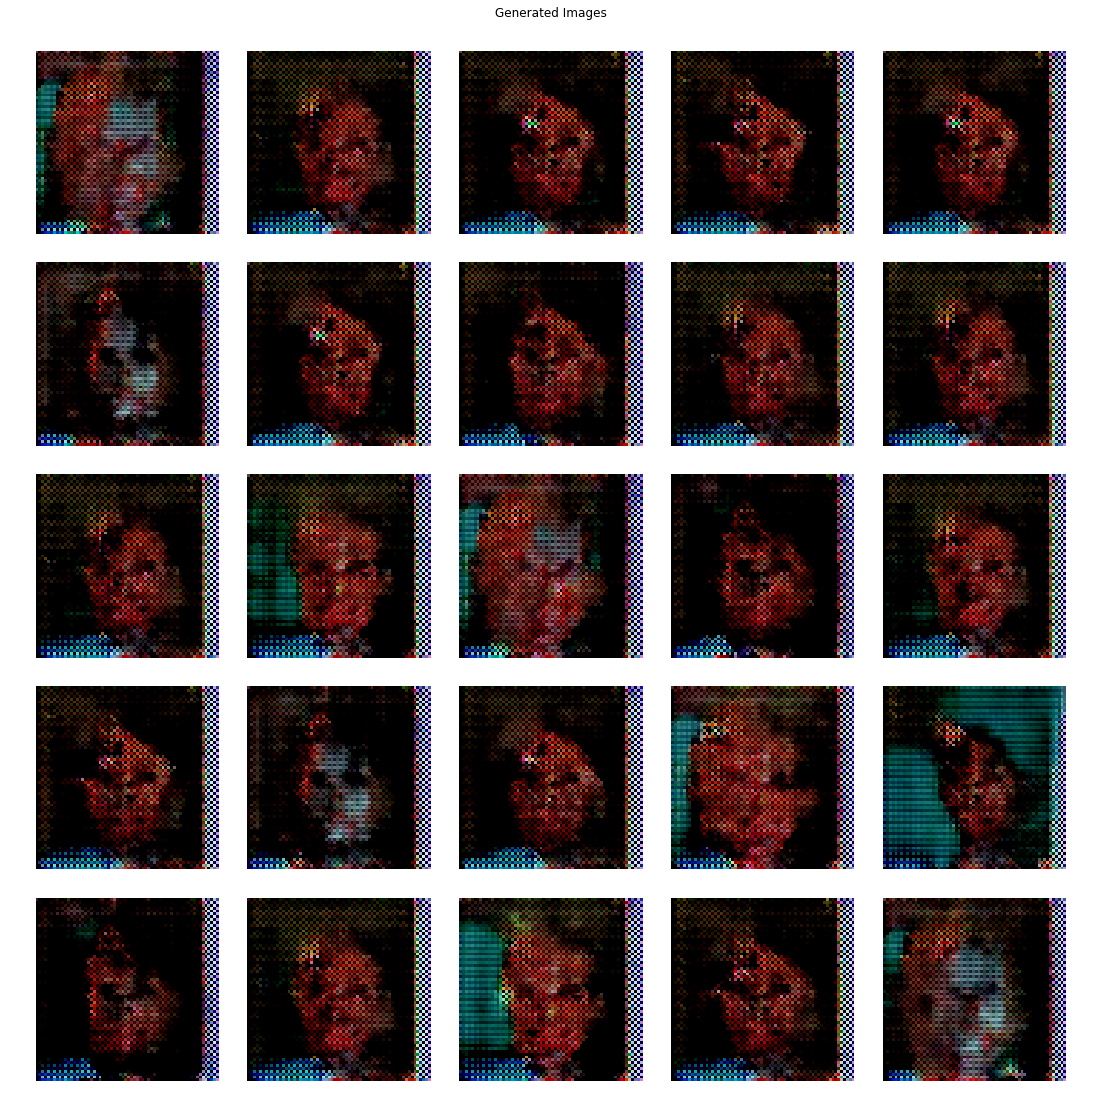

In [42]:
generated = netG(fixed_noise, level=5).detach().cpu().view(-1, 3, 64, 64)


grid = torchvision.utils.make_grid(
    generated,
    nrow=5,
    padding=10,
    pad_value=1,
    normalize=False,
#     range=(-1, 1)
)


plt.figure(figsize=(22, 20))
plt.axis("off")
plt.title("Generated Images")

plt.imshow(
    np.transpose(
        grid,
        (1,2,0)
    )
);